# Project 2 Homework

For this project you're going to apply hyperparameter optimization to both a regression and a classification problem. It looks like a lot to do below, but it's mostly a matter of modifying code from the presentation. 

## Objective

For each of the models in problems 1 and 2 below, apply the following 4 tuning methods from the presentation: GridSearchCV, RandomSearchCV, BayesianOptimization, and TPOT.
* **For TPOT**: In Problem 1 do only hyperparameter optimization. In Problem 2 do **both** hyperparameter optimization and also run TPOT and let it choose the model. See the presentation for examples of both.

### What to submit

For each problem you need to include the following:

1. A pandas table that reports:
    * The best parameters for each tuning method
    * The optimized score from the test data
    * The number of model fits used in the optimization
2. A brief discussion about which hyperparameter optimization approach worked best

### Notes:
* **For problem 1**: your pandas table should include the best parameters for each of the 4 tuning methods above.
* **For problem 2**: your pandas table should include the best parameters for each of the 5 tuning methods (the 4 methods above and the TPOT model search).
* **For GridSearchCV**: you should include at least 2 or 3 values for each hyperparameter and one of those values should be the default.
* **For BayesianOptimization**: you'll have to use `int()` or `bool()` to cast the float values of the hyperparameters inside your `cv_score()` function.
* **For TPOT**: you should use a finer grid than for GridSearchCV, but not more than 10 to 20 possible values for each hyperparameter.  You could lower the number of possible values to keep the search space smaller.
    * If your code is too slow you can reduce the number of cross-validation folds to 3 and if your dataset is really large you can randomly choose a smaller subset of the rows.
* Use section headers to label your work.  Your summary / discussion should be more than simply "XYZ is the best model", but it also shouldn't be more than a few paragraphs and a table.


### Regarding data

* You can use either the specified dataset or you can choose your own.  
    * If you use your own data it should have at least 500 rows and 10 features.  
    * If your data has categorical features you'll need "one hot" encode it (convert categorical features into multiple binary features).  <a href="https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/">Here is a nice tutorial</a>.  For categories with only two values you can remove one of the two hot encoded columns.
* If you do want to use your own data, we suggest first getting things working with the suggested datasets.  Finding, cleaning, and preparing data can take a lot of time.

# **P2.1** - Optimize Random Forest Regression

### Find optimized hyperparameters for a random forest regression model. 

You may use either the diabetes data used in the presentation or a dataset that you choose.  **You do not need to include the TPOT general search for this problem** (use TPOT to optimize RandomForestRegressor, but don't run TPOT to choose a model). Here are ranges for a subset of the hyperparameters:

Hyperparameter |Type | Default Value | Typical Range
---- | ---- | ---- | ----
n_estimators | discrete / integer | 100 | 10 to 150
max_features | continuous / float | 1.0 | 0.05 to 1.0
min_samples_split | discrete / integer | 2 | 2 to 20
min_samples_leaf | discrete / integer | 1 | 1 to 20
bootstrap | discrete / boolean | True | True, False


You can add other hyperparameters to the optimization if you wish.
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">Documentation for sklearn RandomForestRegressor</a>

<font color = "blue"> *** 15 points: </font>

In [1]:
# computational imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from scipy.stats import uniform, randint
from GPyOpt.methods import BayesianOptimization
from tpot import TPOTRegressor, TPOTClassifier
from pprint import pprint

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Model r-squared score from test data: 0.5368
Mean squared error on test data: 2918.49
Root mean squared error on test data: 54.02


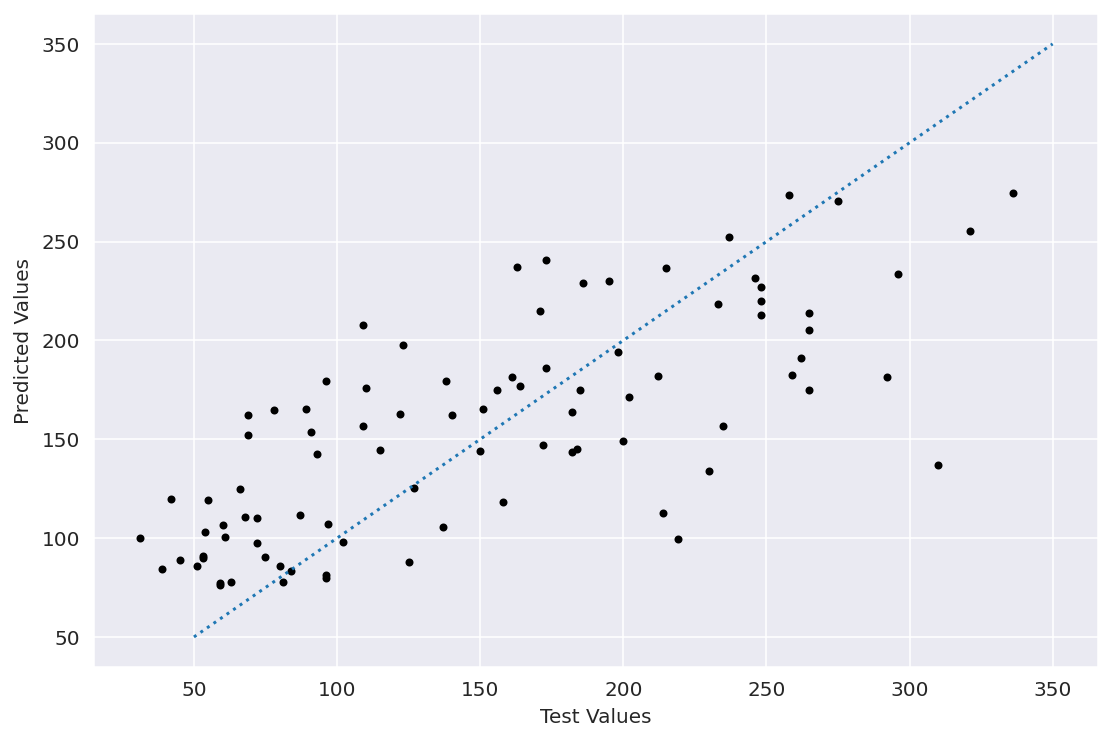

In [2]:
# Load Data
diabetes = load_diabetes()

X = np.array(diabetes.data)
y = np.array(diabetes.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train,y_train)

def my_regression_results(model):
    score_test = model.score(X_test,y_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))

    y_pred = model.predict(X_test)
    
    # plots
    plt.figure(figsize=(9,6))
    plt.plot(y_test,y_pred,'k.')
    x = np.linspace(50, 350, 100)
    plt.plot(x, x+0, linestyle='dotted')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))

my_regression_results(rf_model)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Model r-squared score from test data: 0.5642
Mean squared error on test data: 2745.67
Root mean squared error on test data: 52.40


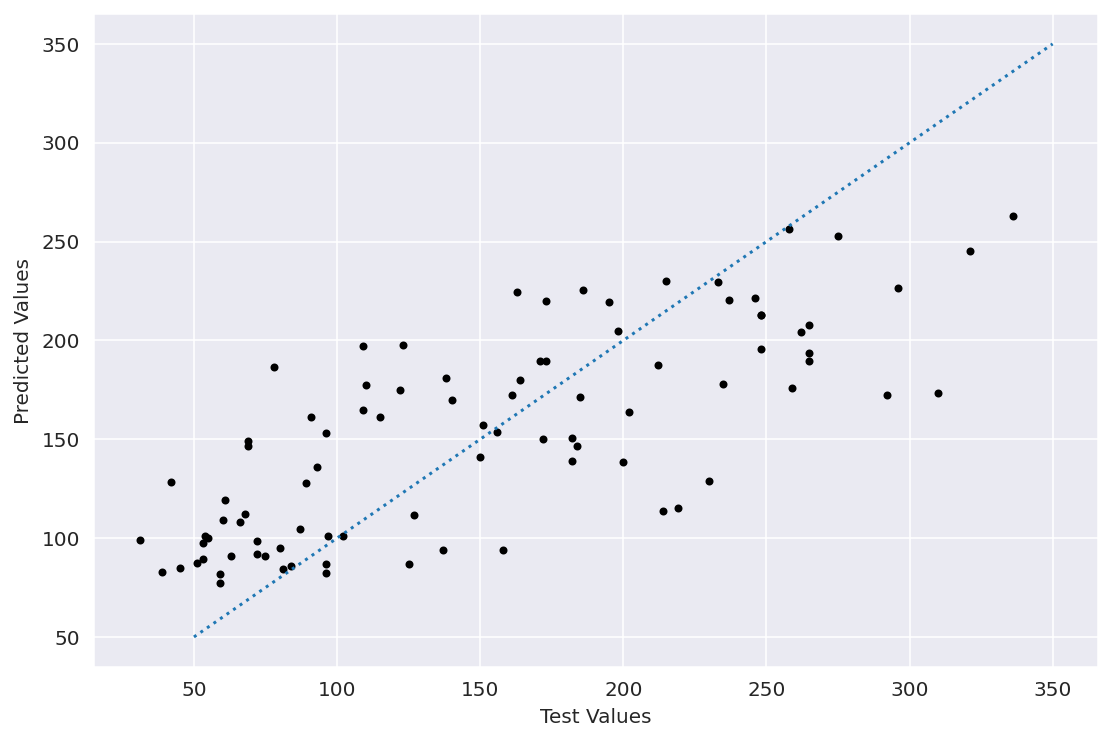

In [3]:
# Grid Search
# define the grid
params = {
    "n_estimators": [10, 100, 150],
    "max_features": [.05, .25, .5, .75, 1.0],
    "min_samples_split": [2, 8, 14, 20],
    "min_samples_leaf": [1, 10, 20],
    "bootstrap": [True, False]
    }

folds = 5
# setup the grid search
grid_search = GridSearchCV(rf_model,
                           param_grid=params,
                           cv=folds,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

grid_params = grid_search.best_params_
grid_params["r2"]=grid_search.score(X_test,y_test)
grid_params["mse"]=mean_squared_error(y_test,grid_search.predict(X_test))
grid_params["rmse"]=np.sqrt(grid_params["mse"])
grid_params["model fits"] = np.prod([len(params[i]) for i in params])*folds
grid = pd.DataFrame(grid_params.values(), grid_params.keys())

my_regression_results(grid_search)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model r-squared score from test data: 0.5702
Mean squared error on test data: 2707.53
Root mean squared error on test data: 52.03


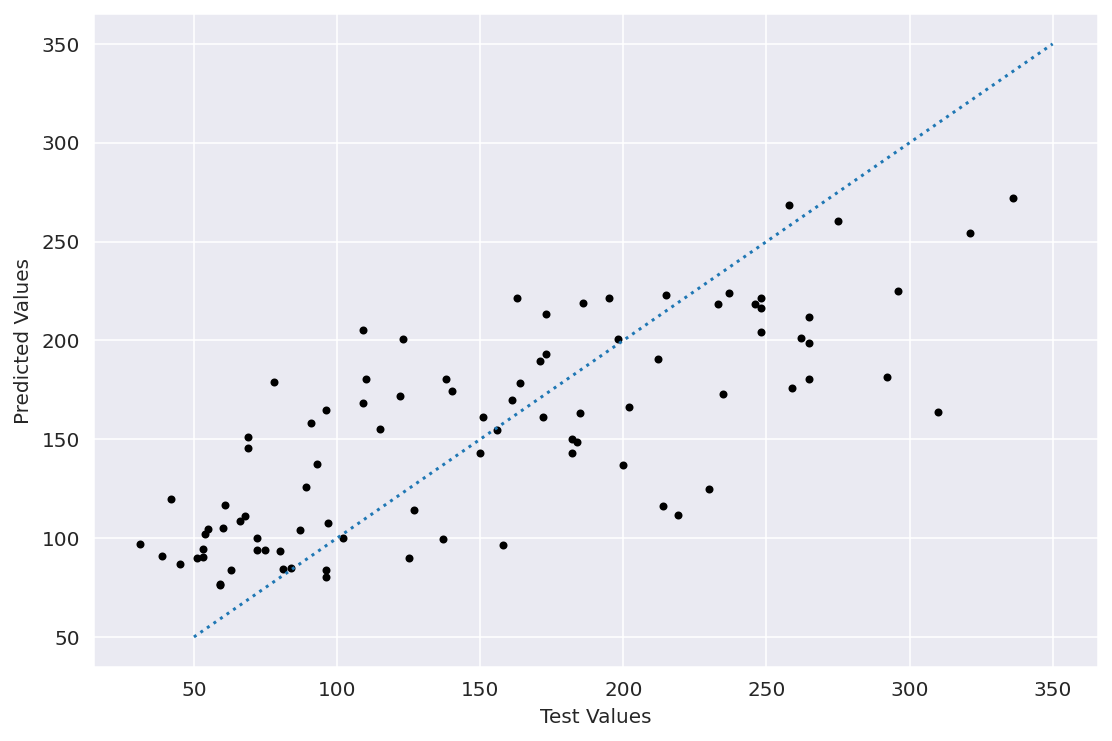

In [4]:
# Random Search
params = {
    "n_estimators": randint(10, 150),
    "max_features": uniform(0.05, 1.0),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "bootstrap": [True, False]
    }

iterations = 50
folds = 5

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    random_state=27,
    n_iter=iterations,
    cv=folds,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

random_search.fit(X_train, y_train)

rand_params = random_search.best_params_
rand_params["r2"]=random_search.score(X_test,y_test)
rand_params["mse"]=mean_squared_error(y_test,random_search.predict(X_test))
rand_params["rmse"]=np.sqrt(rand_params["mse"])
rand_params["model fits"] = iterations * folds
rand = pd.DataFrame(rand_params.values(), rand_params.keys())

my_regression_results(random_search)

Model r-squared score from test data: 0.5458
Mean squared error on test data: 2861.45
Root mean squared error on test data: 53.49


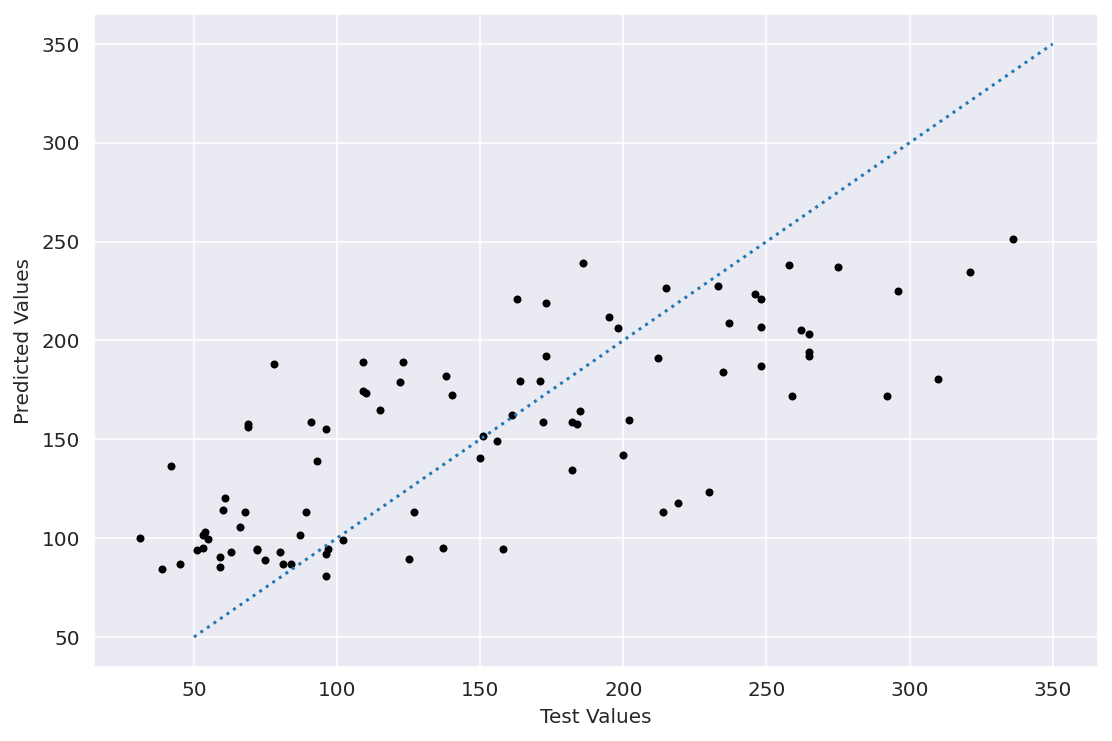

In [5]:
# Bayesian Optimization
np.random.seed(27)

hp_bounds = [{
    'name': "n_estimators",
    'type': 'discrete',
    'domain': (10, 150)
}, {
    'name': 'max_features',
    'type': 'continuous',
    'domain': (0.05, 1.0)
}, {
    'name': 'min_samples_split',
    'type': 'discrete',
    'domain': (2, 20)
}, {
    'name': 'min_samples_leaf',
    'type': 'discrete',
    'domain': (1, 20)
}, {
    'name': 'bootstrap',
    'type': 'discrete',
    'domain': (0, 1)
}]


# Optimization objective
def cv_score(hyp_parameters):
    hyp_parameters = hyp_parameters[0]
    rf_model = RandomForestRegressor(random_state=0, n_estimators=int(hyp_parameters[0]), max_features=hyp_parameters[1],
                                     min_samples_split=hyp_parameters[2], min_samples_leaf=hyp_parameters[3],
                                     bootstrap=bool(hyp_parameters[4]))
                                    
    scores = cross_val_score(rf_model,
                             X=X_train,
                             y=y_train,
                             cv=KFold(n_splits=folds))
    return np.array(scores.mean())  # return average of 5-fold scores


optimizer = BayesianOptimization(f=cv_score,
                                 domain=hp_bounds,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 acquisition_jitter=0.05,
                                 exact_feval=True,
                                 maximize=True,
                                 verbosity=True)
max_iter = 50
folds = 5
optimizer.run_optimization(max_iter=max_iter,verbosity=False)

bayes_params = {}
for i in range(len(hp_bounds)):
    if hp_bounds[i]['type'] == 'continuous':
        bayes_params[hp_bounds[i]['name']] = optimizer.x_opt[i]
    else:
        bayes_params[hp_bounds[i]['name']] = int(optimizer.x_opt[i])

bayopt_search = RandomForestRegressor(**bayes_params)
bayopt_search.fit(X_train,y_train)
bayes_params["r2"]=bayopt_search.score(X_test,y_test)
bayes_params["mse"]=mean_squared_error(y_test,bayopt_search.predict(X_test))
bayes_params["rmse"]=np.sqrt(bayes_params["mse"])
bayes_params["bootstrap"]=bool(bayes_params["bootstrap"])
bayes_params["model fits"]=(max_iter + 5) * folds
bayes = pd.DataFrame(bayes_params.values(), bayes_params.keys())
my_regression_results(bayopt_search)

Model r-squared score from test data: 0.5512
Mean squared error on test data: 2827.56
Root mean squared error on test data: 53.17


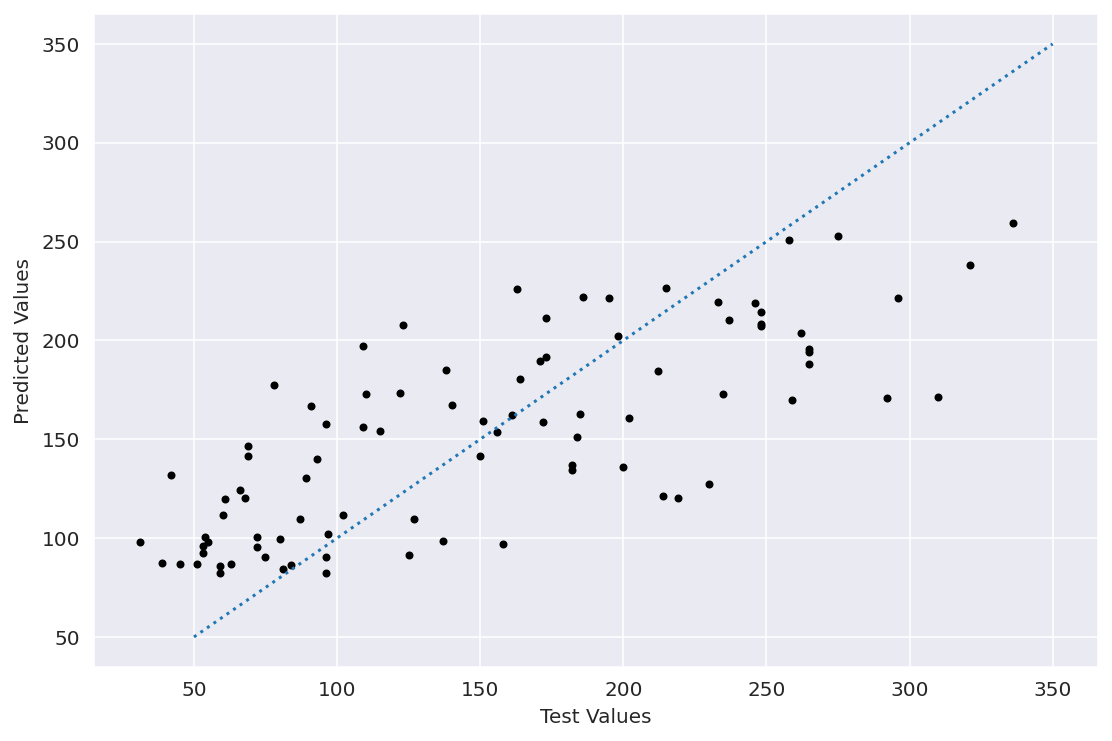

In [6]:
# TPOT
pop_size = 20
iterations = 20
folds = 5

tpot_config = {
    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': range(10,151),
        'max_features': np.arange(0.05,1.0,.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': range(0,2),
    }
}

tpot_reg = TPOTRegressor(scoring = 'r2',
                     generations=iterations,
                     population_size=pop_size,
                     verbosity=0,
                     config_dict=tpot_config,
                     cv=folds,
                     template='Regressor', #no stacked models
                     random_state=27)

tpot_reg.fit(X_train, y_train)
tpot_reg.export('tpot_RFregressor.py') # export the model

my_regression_results(tpot_reg)

In [7]:
tpot_reg.fitted_pipeline_

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=1, max_features=0.45,
                                       min_samples_leaf=7, min_samples_split=12,
                                       n_estimators=123, random_state=27))])

In [8]:
tpot = {}
tpot["bootstrap"] = True
tpot["max_features"] = 0.45
tpot["min_samples_leaf"] = 7
tpot["min_samples_split"] = 12
tpot["n_estimators"] = 123
tpot["r2"]=0.5512
tpot["mse"]=2827.56
tpot["rmse"]=np.sqrt(tpot["mse"])
tpot["model fits"]=pop_size * (iterations + 1) * folds
tpot = pd.DataFrame(tpot.values(), tpot.keys())

In [9]:
all_params = pd.concat([grid, rand, bayes, tpot], axis=1, ).fillna("")
all_params.columns=["Grid Search", "Randomized Search", "Bayesian Optimization", "TPOT"]
all_params

,Grid Search,Randomized Search,Bayesian Optimization,TPOT
bootstrap,True,True,True,True
max_features,0.75,0.789411,0.892461,0.45
min_samples_leaf,10,6,20,7
min_samples_split,2,13,2,12
n_estimators,100,82,150,123
r2,0.564191,0.570244,0.545814,0.5512
mse,2745.670523,2707.533258,2861.44854,2827.56
rmse,52.399146,52.033963,53.492509,53.174806
model fits,1800,250,275,2100


### Summary:
<font color = "blue"> *** 5 points: </font>

<font color = "green">
When I wrote this, Randomized Search performed better than the other methods. Each method was fairly intuitive to use (though I ran out of time before I figured out how to extract features from TPOT). Randomized Search was also the fastest method, by far.  I suspect it would be different for each scenario. Overall, there was very minimal improvement using any of the methods. It seems the defaults are fairly well researched.
</font>

# **P2.2** - Optimize XGBoost Classifier

### Find optimized hyperparameters for an xgboost classifier model. 

This problem contains 5 parts.


### Notes:

#### About the data
The first cell below loads a subset of the loans default data from DS705 and your job is to predict whether a loan defaults or not.  The `status_bad` column is the target column and a 1 indicates a loan that defaulted.  We have selected a subset of the original data that includes 2000 each of good and bad loans.  The data has already been cleaned and encoded.  You're welcome to look into a different dataset, but start by getting this working and then add your own data.

#### This is classification, not regression
The score for each model will be accuracy and not MSE.  Your summary table should include accuracy, sensitivity, and precision for each optimized model applied to the test data.  (<a href="https://classeval.wordpress.com/introduction/basic-evaluation-measures/">Here is a nice overview of metrics for binary classification data</a>) that includes definitions of accuracy and such.

For the models you'll mostly just need to change 'regressor' to 'classifier', e.g. `XGBClassifier` instead of `XGBRegressor`.


Hyperparameter | Type | Default Value | Typical Range
---- | ---- | ---- | ----
n_estimators | discrete / integer | 100 | 10 to 150
max_depth | discrete / integer | 3| 1 to 10
min_child_weight | discrete / integer | 1 | 1 to 20
learning_rate | continuous / float | 0.1 | 0.001 to 1
subsample | continuous / float | 1 | 0.05 to 1
reg_lambda | continuous / float | 1 | 0 to 5
reg_alpha  | continuous / float | 0 | 0 to 5

## **P2.2a** - Loading the Data

In [10]:
# Do not change this cell for loading and preparing the data
import pandas as pd
import numpy as np

X = pd.read_csv('./data/loans_subset.csv')

# split into predictors and target
# convert to numpy arrays for xgboost, OK for other models too
y = np.array(X['status_Bad']) # 1 for bad loan, 0 for good loan
X = np.array(X.drop(columns = ['status_Bad']))

# split into test and training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## **P2.2b** - Display Results Function

Write a function called `my_classifier_results` modeled after `my_regression_results` that applies a model to the test data and prints out the accuracy, sensitivity, precision, and the confusion matrix.  There is no need to make a plot.

<font color = "blue"> *** 5 points - (don't delete this cell) </font>

In [11]:
def my_classifier_results(model): 
    #get predictions
    y_pred = model.predict(X_test)
    #get the classification report
    cr = classification_report(y_test, y_pred, output_dict=True)
    accuracy = cr['accuracy'] #total number of correct predictions (positive or negative)
    sensitivity = cr['1']['recall'] #true positive rate - accurately predicting a default when they are - 1 is best
    precision = cr['1']['precision'] #positive predictive value - 1 is best
    specificity = cr['0']['recall'] #true negative rate - accurately predicting not a default when they aren't
    #get the area under curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    model_name = str(model).split('(')[0]
    print('\nModel:', model_name)
    print('------------------------------------------------------------')

    cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[1,0]), 
    index=['true: default', 'true: no default'], 
    columns=['pred: default','pred: no default']
    )
    display(cmtx)
    output = {"Accuracy":accuracy, "AUC":auc, "Sensitivity":sensitivity, "Precision":precision, "Specificity":specificity}
    return output, model_name

## **P2.2c** - Baseline Models

Start by training some baseline models using default values of the hyperparameters.  We've included logistic regression in a cell below to get you started.  Use `LogisticRegression`, `RandomForestClassifier`, and `GaussianNB` (Gaussian Naive Bayes) from `sklearn`.  Also use `XGBClassifier` from `xgboost` where you may need to include `objective="binary:logistic"` as an option. The default scoring method for all of the `sklearn` classifiers is accuracy. Apply `my_classifier_results` to the test data for each model.

<font color = "blue"> *** 10 points - (don't delete this cell) </font>

In [12]:
# We've included this code to get you started

# we do need to go higher than the default iterations for the solver to get convergence
# and the explicity declaration of the solver avoids a warning message, otherwise
# the parameters are defaults.


# Logistic Regression
logreg_model = LogisticRegression(solver='lbfgs',max_iter=1000)
logreg_model.fit(X_train, y_train)
log_dict, log_model_name = my_classifier_results(logreg_model)
log_table = pd.DataFrame(log_dict.values(), log_dict.keys())
log_table.columns=[log_model_name]


# Random Forest
rfClassifier = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')
rfClassifier.fit(X_train, y_train)
rf_dict, rf_model_name = my_classifier_results(rfClassifier)
rf_table = pd.DataFrame(rf_dict.values(), rf_dict.keys())
rf_table.columns=[rf_model_name]

# Gaussian Naive Bayes
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_dict, gnb_model_name = my_classifier_results(gnb_model)
gnb_table = pd.DataFrame(gnb_dict.values(), gnb_dict.keys())
gnb_table.columns=[gnb_model_name]

# XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(X_train, y_train)
xgb_dict, xgb_model_name = my_classifier_results(xgb_model)
xgb_table = pd.DataFrame(xgb_dict.values(), xgb_dict.keys())
xgb_table.columns=[xgb_model_name]

all_table = pd.concat([log_table, rf_table, gnb_table, xgb_table], axis=1)
all_table


Model: LogisticRegression
------------------------------------------------------------


,pred: default,pred: no default
true: default,126,71
true: no default,110,93



Model: RandomForestClassifier
------------------------------------------------------------


,pred: default,pred: no default
true: default,129,68
true: no default,74,129



Model: GaussianNB
------------------------------------------------------------


,pred: default,pred: no default
true: default,160,37
true: no default,139,64



Model: XGBClassifier
------------------------------------------------------------


,pred: default,pred: no default
true: default,121,76
true: no default,70,133


,LogisticRegression,RandomForestClassifier,GaussianNB,XGBClassifier
Accuracy,0.547500,0.645000,0.560000,0.635000
AUC,0.548861,0.645145,0.563727,0.634693
Sensitivity,0.639594,0.654822,0.812183,0.614213
Precision,0.533898,0.635468,0.535117,0.633508
Specificity,0.458128,0.635468,0.315271,0.655172


## **P2.2d** - Hyperparameter Optimization

Now use the four hyperparameter optimization techniques on `XGBClassifier` and TPOT general model optimization.  Apply `my_classifer_results` to the test data in each case.
* Feel free to use 3 folds instead of 5 for cross validation to speed things up. 
* Choose a very small number of iterations, population size, etc. until you're sure things are working correctly, then turn up the numbers.  General TPOT optimization will take a while (fair warning: it took about 30 minutes on my Macbook Pro with generations = 10, population_size=40, and cv=5)  
* The hyperparameters to consider are the same as they were in the presentation , but here they are again for convenience:

Hyperparameter | Default Value | Typical Range
---- | ---- | ----
n_estimators | 100 | 10 to 100
max_depth | 3 | 1 to 10
min_child_weight | 1 | 1 to 20
learning_rate | 0.1 | 0.001 to 1
sub_sample | 1 | 0.05 to 1
reg_lambda | 1 | 0 to 5
reg_alpha  | 0 | 0 to 5

<font color = "blue"> *** 10 points - (don't delete this cell) </font>

In [13]:
# Grid Search
params = {
    "learning_rate": [0.01, 0.1], #pick floats from 0 to 1
    "max_depth": [2, 4, 6], #pick integers in range [0,inf] (but you'd usually want at least 1)
    "n_estimators": [50, 100, 150], #number of trees. Default is 100
    "subsample": [0.8, 1], #pick floats from 0 to 1
    "min_child_weight": [1, 3], #pick numbers 0 to inf
    "reg_lambda": [1, 3], #pick numbers from 0 to inf
    "reg_alpha": [1, 3] #pick numbers from 0 to inf
}

# setup the grid search
grid_search = GridSearchCV(xgb_model,
                           param_grid=params,
                           cv=3,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

#fit the model
grid_search.fit(X_train, y_train)
grid_dict, grid_model_name = my_classifier_results(grid_search)
grid_table = pd.DataFrame(grid_dict.values(), grid_dict.keys())
grid_table.columns=[grid_model_name]


Fitting 3 folds for each of 288 candidates, totalling 864 fits

Model: GridSearchCV
------------------------------------------------------------


,pred: default,pred: no default
true: default,135,62
true: no default,85,118


In [15]:
# Bayesian Optimization
hp_bounds = [{
    'name': 'learning_rate',
    'type': 'continuous',
    'domain': (0.001, 1.0)
}, {
    'name': 'max_depth',
    'type': 'discrete',
    'domain': (1, 10)
}, {
    'name': 'n_estimators',
    'type': 'discrete',
    'domain': (10, 100)
}, {
    'name': 'subsample',
    'type': 'continuous',
    'domain': (0.05, 1.0)
}, {
    'name': 'min_child_weight',
    'type': 'discrete',
    'domain': (1, 20)
}, {
    'name': 'reg_alpha',
    'type': 'continuous',
    'domain': (0, 5)
}, {
    'name': 'reg_lambda',
    'type': 'continuous',
    'domain': (0, 5)
}]


# Optimization objective
def cv_score(hyp_parameters):
    hyp_parameters = hyp_parameters[0]
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                 learning_rate=hyp_parameters[0],
                                 max_depth=int(hyp_parameters[1]),
                                 n_estimators=int(hyp_parameters[2]),
                                 subsample=hyp_parameters[3],
                                 min_child_weight=int(hyp_parameters[4]),
                                 reg_alpha=hyp_parameters[5],
                                 reg_lambda=hyp_parameters[6])
    scores = cross_val_score(xgb_model,
                             X=X_train,
                             y=y_train,
                             cv=KFold(n_splits=5))
    return np.array(scores.mean())  # return average of 5-fold scores


optimizer = BayesianOptimization(f=cv_score,
                                 domain=hp_bounds,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 acquisition_jitter=0.05,
                                 exact_feval=True,
                                 maximize=True,
                                 verbosity=False)

optimizer.run_optimization(max_iter=20,verbosity=True)

best_hyp_set = {}
for i in range(len(hp_bounds)):
    if hp_bounds[i]['type'] == 'continuous':
        best_hyp_set[hp_bounds[i]['name']] = optimizer.x_opt[i]
    else:
        best_hyp_set[hp_bounds[i]['name']] = int(optimizer.x_opt[i])
        
bayopt_search = xgb.XGBClassifier(objective="binary:logistic",**best_hyp_set)        

#fit the model
bayopt_search.fit(X_train, y_train)
bayes_dict, bayes_model_name = my_classifier_results(bayopt_search)
bayes_table = pd.DataFrame(bayes_dict.values(), bayes_dict.keys())
bayes_table.columns=[bayes_model_name]

num acquisition: 1, time elapsed: 12.40s
num acquisition: 2, time elapsed: 30.92s
num acquisition: 3, time elapsed: 48.00s
num acquisition: 4, time elapsed: 65.00s
num acquisition: 5, time elapsed: 86.71s
num acquisition: 6, time elapsed: 116.20s
num acquisition: 7, time elapsed: 121.82s
num acquisition: 8, time elapsed: 134.70s
num acquisition: 9, time elapsed: 148.50s
num acquisition: 10, time elapsed: 154.51s
num acquisition: 11, time elapsed: 162.80s
num acquisition: 12, time elapsed: 170.60s
num acquisition: 13, time elapsed: 180.10s
num acquisition: 14, time elapsed: 188.52s
num acquisition: 15, time elapsed: 197.05s
num acquisition: 16, time elapsed: 210.52s
num acquisition: 17, time elapsed: 221.90s
num acquisition: 18, time elapsed: 230.72s
num acquisition: 19, time elapsed: 238.31s
num acquisition: 20, time elapsed: 250.33s

Model: XGBClassifier
------------------------------------------------------------


,pred: default,pred: no default
true: default,132,65
true: no default,87,116


In [47]:
# TPOT
tpot_config = {
    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'reg_alpha': range(1, 6),
        'reg_lambda': range(1, 6),
        'nthread': [2],
        'objective': ['binary:logistic']
       
    }
}

tpot = TPOTClassifier(generations=10,
                     population_size=40,
                     verbosity=0,
                     config_dict=tpot_config,
                     cv=3,
                     scoring='balanced_accuracy',
                     random_state=27,
                     template = 'Classifier')


#fit the model
tpot.fit(X_train, y_train)
tpot_dict, tpot_model_name = my_classifier_results(tpot)
tpot.export('tpot_XGBClassifier_loans.py')
tpot_table = pd.DataFrame(tpot_dict.values(), tpot_dict.keys())
tpot_table.columns=[tpot_model_name]




Model: TPOTClassifier
------------------------------------------------------------


,pred: default,pred: no default
true: default,141,56
true: no default,82,121


In [48]:
tpot.fitted_pipeline_

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=7, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=2, nthread=2, num_parallel_tree=1,
                               random_state=27, reg_alpha=1, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.45,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [65]:
# TPOT AutoML
tpot_a = TPOTClassifier(scoring = 'r2',
                     generations=10,
                     population_size=40,
                     verbosity=0,
                     cv=5,
                     random_state=27,
                     template = 'Classifier',
                     config_dict='TPOT light')
tpot_a.fit(X_train, y_train)
tpot_a.export('tpot_optimal_pipeline.py')
tpot_a_dict, tpot_a_model_name = my_classifier_results(tpot_a)
tpot_a_table = pd.DataFrame(tpot_a_dict.values(), tpot_a_dict.keys())
tpot_a_table.columns=['TPOT Auto ML']


Model: TPOTClassifier
------------------------------------------------------------


,pred: default,pred: no default
true: default,126,71
true: no default,77,126


In [68]:
tpot_a.fitted_pipeline_


Pipeline(steps=[('bernoullinb', BernoulliNB())])

In [69]:
# final output
# this is a mess, but the amount of time it took to run each method prohibited making changes
new_table = pd.DataFrame(grid_search.best_params_.values(), grid_search.best_params_.keys())
new_table.columns=["Grid Search"]
grid_table.columns=["Grid Search"]
grid_params_table = new_table.append(grid_table)
new_rand_table = pd.DataFrame(random_search.best_params_.values(), random_search.best_params_.keys())
new_rand_table.columns=["Randomized Search"]
rand_table.columns=["Randomized Search"]
rand_params_table = new_rand_table.append(rand_table)
new_bayes_table = pd.DataFrame(best_hyp_set.values(), best_hyp_set.keys())
new_bayes_table.columns=["Bayesian Optimization"]
bayes_table.columns=["Bayesian Optimization"]
bayes_params_table = new_bayes_table.append(bayes_table)
tpot_params_dict = {"learning_rate":0.001, "max_depth":4, "min_child_weight":7, "n_estimators":100, "reg_alpha":1, "reg_lambda":1, "subsample":0.45}
tpot_new_table=pd.DataFrame(tpot_params_dict.values(),tpot_params_dict.keys())
tpot_new_table.columns=[tpot_model_name]
tpot_params_table=tpot_new_table.append(tpot_table)
final_table = pd.concat([grid_params_table, rand_params_table, bayes_params_table,tpot_params_table,tpot_a_table], axis=1)
final_table

,Grid Search,Randomized Search,Bayesian Optimization,TPOTClassifier,TPOT Auto ML
learning_rate,0.010000,0.100000,0.616974,0.001000,NaN
max_depth,2.000000,4.000000,1.000000,4.000000,NaN
min_child_weight,1.000000,2.000000,1.000000,7.000000,NaN
n_estimators,150.000000,65.000000,10.000000,100.000000,NaN
reg_alpha,1.000000,1.052794,4.038743,1.000000,NaN
reg_lambda,1.000000,0.487552,1.418258,1.000000,NaN
subsample,1.000000,0.960852,0.970270,0.450000,NaN
Accuracy,0.632500,0.662500,0.620000,0.655000,0.630000
AUC,0.633280,0.662687,0.620740,0.655898,0.630142
Sensitivity,0.685279,0.675127,0.670051,0.715736,0.639594


## **P2.2e** - Summary

* In addition to your summary table, answer:
    * The bank isn't as concerned about misclassifying some truly good loans as they are interested in correctly predicting truly bad loans.  Which model should they use?  Why?

<font color = "blue"> *** 5 points - (don't delete this cell) </font>

<font color = "green">
The best accuracy came from Randomized Search. It is possible that better results could be achieved if I spent more time tweaking the hyperparameters of all the methods.  The amount of time it took to run each method prohibited thorough experimentation. 
If the bank was solely concerned with true positives, they might consider using the first TPOT model. Its sensitivity was the highest, though its overall accuracy was slightly lower than Randomized Search.  
</font>

# **P2.3** - Extra Credit - Problem 3 (up to 10 extra points)

Show how to use the `pycaret` package to do model selection for one of the two problems above.  We've never used `pycaret` but it looks promising.  We have used the `caret` package in R and it simplifies many machine learning tasks considerably.

Use Google to search for `pycaret` to get started.